In [26]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
#from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D, MaxPool2D, Lambda
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
data = '../input/covid-19-x-ray-10000-images/dataset'
os.listdir(data)

['normal', 'covid']

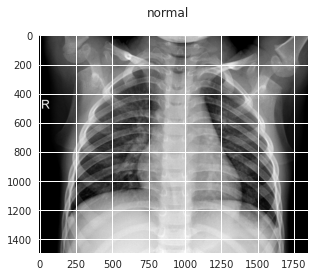

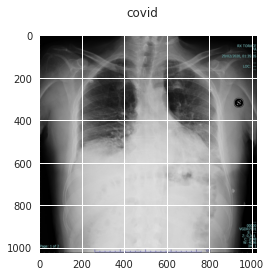

In [28]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

normal_images = []
for img_path in glob.glob(data + '/normal/*'):
    normal_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('normal')
plt.imshow(normal_images[0], cmap='gray') 

covid_images = []
for img_path in glob.glob(data + '/covid/*'):
    covid_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('covid')
plt.imshow(covid_images[0], cmap='gray') 

In [29]:
print(len(normal_images))
print(len(covid_images))

28
70


In [30]:
input_shape = (150, 150, 3)
classes  = 2
epochs = 20
batch_size = 6

In [31]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(Conv2D(250,(3,3)))
model.add(Activation("relu"))
model.add(Dropout(0.2))



  
model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))
model.add(Dropout(0.2))


model.add(Conv2D(256,(2,2)))
model.add(Activation("relu"))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

    
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation("sigmoid"))

In [32]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_8 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_9 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 64)       

In [34]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    data, 
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary',
    shuffle= False,
    subset='validation')

Found 79 images belonging to 2 classes.
Found 19 images belonging to 2 classes.


In [35]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("cnn.h5", monitor='accuracy', verbose=1, save_best_only=True)

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=20)

In [36]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = epochs,
 callbacks=[callback,checkpoint]
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
13/13 [==============================] - 8s 505ms/step - loss: 7.5383 - accuracy: 0.6849 - val_loss: 0.6606 - val_accuracy: 0.7778

Epoch 00001: accuracy improved from -inf to 0.68493, saving model to cnn.h5
Epoch 2/20
13/13 [==============================] - 6s 438ms/step - loss: 0.6828 - accuracy: 0.6301 - val_loss: 0.6217 - val_accuracy: 0.7778

Epoch 00002: accuracy did not improve from 0.68493
Epoch 3/20
13/13 [==============================] - 6s 424ms/step - loss: 0.6712 - accuracy: 0.6849 - val_loss: 0.5362 - val_accuracy: 0.7778

Epoch 00003: accuracy did not improve from 0.68493
Epoch 4/20
13/13 [==============================] - 6s 483ms/step - loss: 0.7288 - accuracy: 0.6849 - val_loss: 0.5888 - val_accuracy: 0.7778

Epoch 00004: accuracy did not improve from 0.68493
Epoch 5/20
13/13 [==============================] - 6s 464ms/step - loss: 0.6259 - accuracy: 0.7123 - val_loss: 0.6131 - val_accuracy: 0.7778

Epoch 00005: accuracy improved from 0.68493 to 0.71233, 

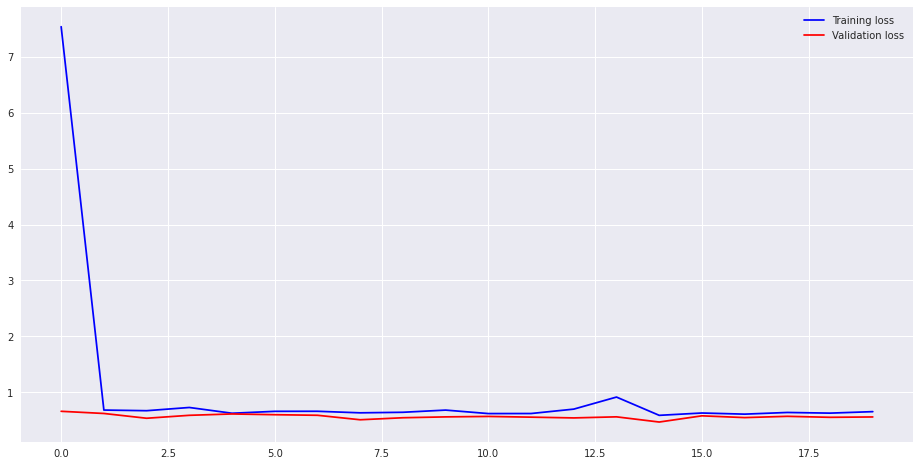

<Figure size 576x396 with 0 Axes>

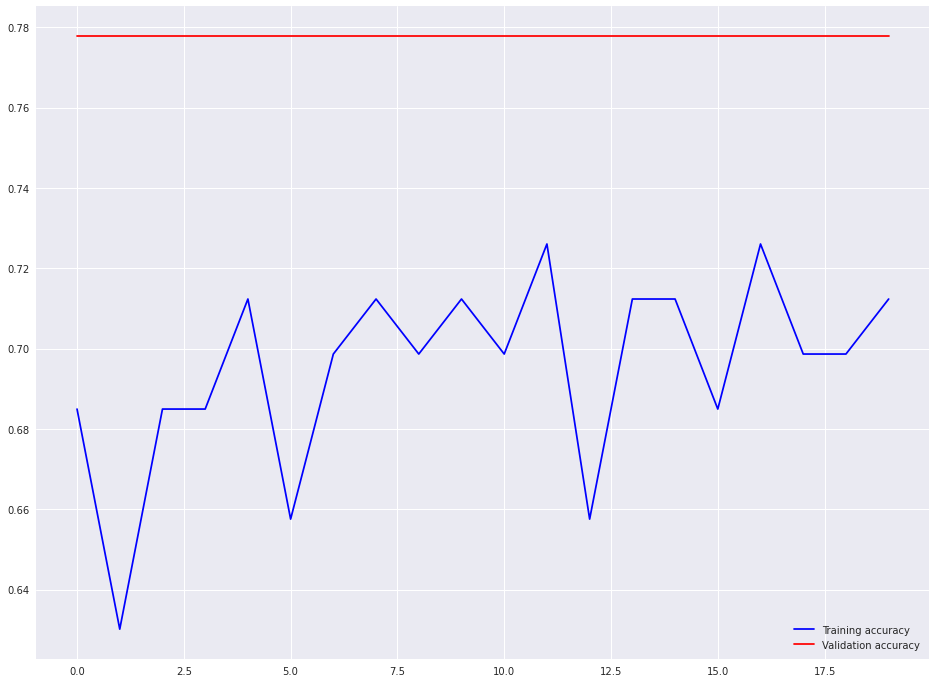

In [37]:
plt.style.use('seaborn')
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(16,12))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.show()

In [38]:
model.evaluate(validation_generator)

4/4 [==============================] - 1s 220ms/step - loss: 0.5872 - accuracy: 0.7368


[0.5872113108634949, 0.7368420958518982]

In [39]:
model.evaluate(train_generator)

14/14 [==============================] - 3s 234ms/step - loss: 0.6065 - accuracy: 0.7089


[0.6064978837966919, 0.7088607549667358]

In [40]:
INPUT_SHAPE = (150,150,3) 

In [41]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input


vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(150,150,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model2 = Sequential()
model2.add(vgg19)
model2.add(Flatten())
model2.add(Dense(1,activation='sigmoid'))
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 8193      
Total params: 20,032,577
Trainable params: 8,193
Non-trainable params: 20,024,384
_________________________________________________________________


In [42]:
model2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [43]:
history_vgg19 = model2.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 5,
 callbacks=[callback,checkpoint]
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
13/13 [==============================] - 17s 1s/step - loss: 0.5783 - accuracy: 0.8082 - val_loss: 0.2268 - val_accuracy: 1.0000

Epoch 00001: accuracy improved from 0.72603 to 0.80822, saving model to cnn.h5
Epoch 2/5
13/13 [==============================] - 15s 1s/step - loss: 0.1607 - accuracy: 0.9726 - val_loss: 0.1314 - val_accuracy: 1.0000

Epoch 00002: accuracy improved from 0.80822 to 0.97260, saving model to cnn.h5
Epoch 3/5
13/13 [==============================] - 15s 1s/step - loss: 0.1574 - accuracy: 0.9452 - val_loss: 0.1376 - val_accuracy: 0.9444

Epoch 00003: accuracy did not improve from 0.97260
Epoch 4/5
13/13 [==============================] - 16s 1s/step - loss: 0.0579 - accuracy: 1.0000 - val_loss: 0.0797 - val_accuracy: 1.0000

Epoch 00004: accuracy improved from 0.97260 to 1.00000, saving model to cnn.h5
Epoch 5/5
13/13 [==============================] - 15s 1s/step - loss: 0.0424 - accuracy: 1.0000 - val_loss: 0.1423 - val_accuracy: 0.9444

Epoch 00005:

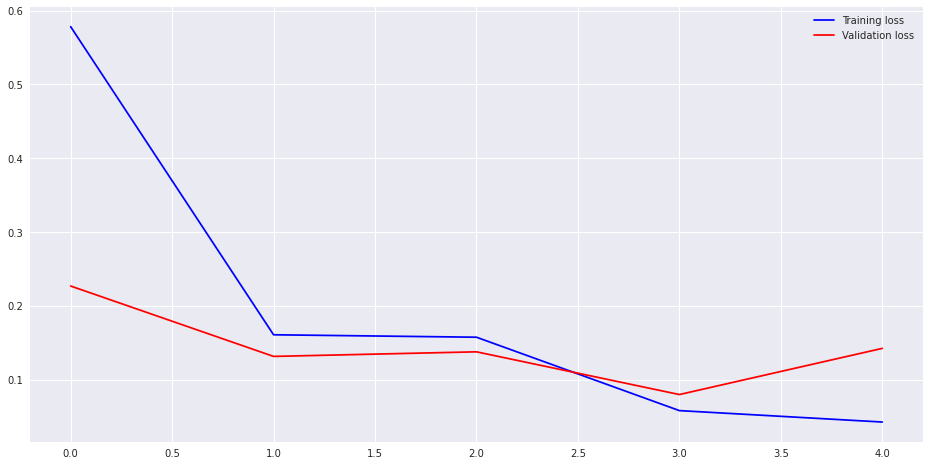

<Figure size 576x396 with 0 Axes>

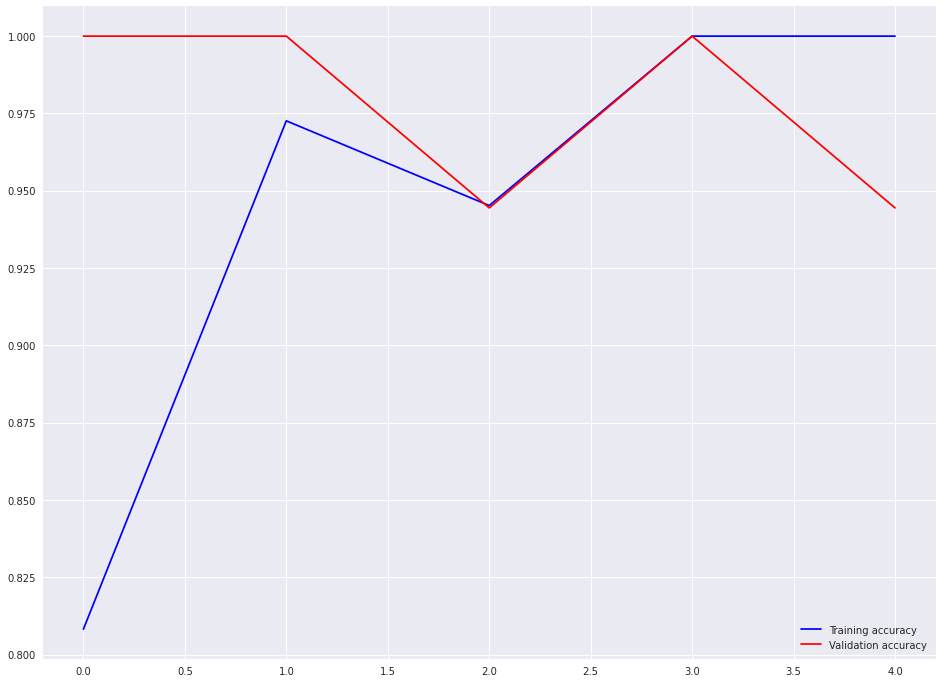

In [44]:
plt.style.use('seaborn')
plt.figure(figsize=(16,8))
plt.plot(history_vgg19.history['loss'], color='b', label="Training loss")
plt.plot(history_vgg19.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(16,12))
plt.plot(history_vgg19.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history_vgg19.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.show()

In [45]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input


vgg16 = VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))

for layer in vgg16.layers:
    layer.trainable = False
    
model3 = Sequential()
model3.add(vgg16)
model3.add(Flatten())
model3.add(Dense(1,activation='sigmoid'))
model3.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 8193      
Total params: 14,722,881
Trainable params: 8,193
Non-trainable params: 14,714,688
_________________________________________________________________


In [46]:
model3.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [47]:
history_vgg16 = model3.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 10,
 callbacks=[callback,checkpoint]
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
13/13 [==============================] - 15s 1s/step - loss: 0.4404 - accuracy: 0.7945 - val_loss: 0.2083 - val_accuracy: 1.0000

Epoch 00001: accuracy did not improve from 1.00000
Epoch 2/10
13/13 [==============================] - 13s 967ms/step - loss: 0.1789 - accuracy: 0.9589 - val_loss: 0.1380 - val_accuracy: 1.0000

Epoch 00002: accuracy did not improve from 1.00000
Epoch 3/10
13/13 [==============================] - 13s 985ms/step - loss: 0.0803 - accuracy: 1.0000 - val_loss: 0.0717 - val_accuracy: 1.0000

Epoch 00003: accuracy did not improve from 1.00000
Epoch 4/10
13/13 [==============================] - 13s 973ms/step - loss: 0.0625 - accuracy: 1.0000 - val_loss: 0.0390 - val_accuracy: 1.0000

Epoch 00004: accuracy did not improve from 1.00000
Epoch 5/10
13/13 [==============================] - 13s 1s/step - loss: 0.0325 - accuracy: 1.0000 - val_loss: 0.0412 - val_accuracy: 1.0000

Epoch 00005: accuracy did not improve from 1.00000
Epoch 6/10
13/13 [=============

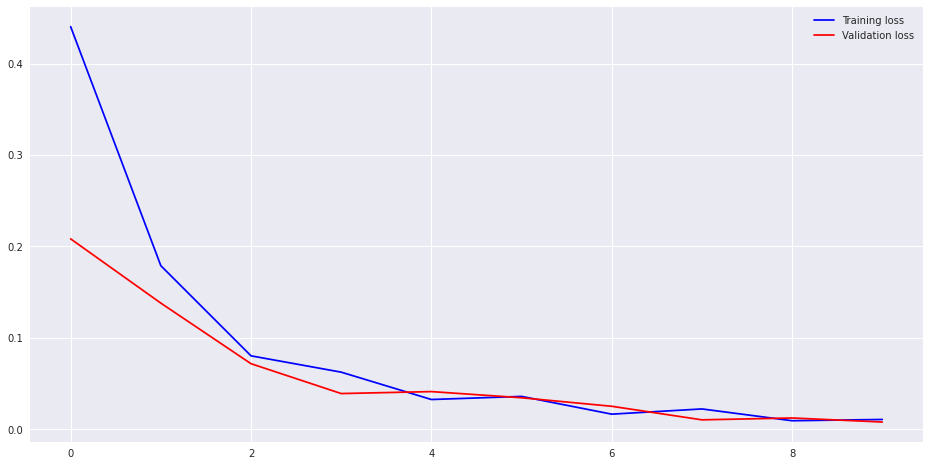

<Figure size 576x396 with 0 Axes>

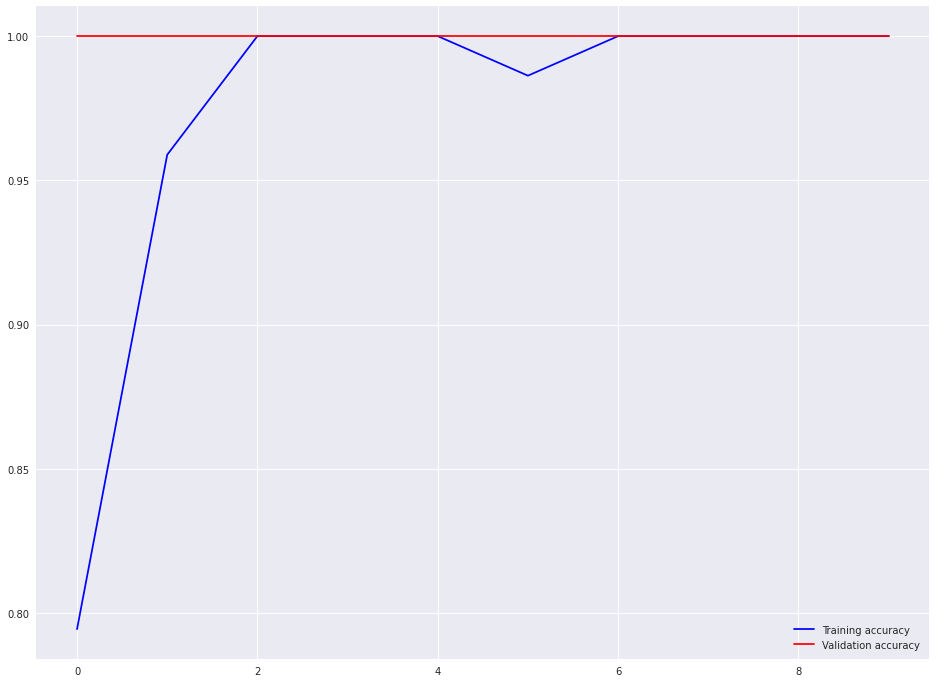

In [48]:
plt.style.use('seaborn')
plt.figure(figsize=(16,8))
plt.plot(history_vgg16.history['loss'], color='b', label="Training loss")
plt.plot(history_vgg16.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(16,12))
plt.plot(history_vgg16.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history_vgg16.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.show()

In [50]:
from tensorflow.keras.applications.resnet50 import ResNet50


ResNet50 = ResNet50(weights='imagenet',include_top=False,input_shape=(150,150,3))

for layer in ResNet50.layers:
    layer.trainable = False
    
model4 = Sequential()
model4.add(ResNet50)
model4.add(Flatten())
model4.add(Dense(1,activation='sigmoid'))
model4.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51201     
Total params: 23,638,913
Trainable params: 51,201
Non-trainable params: 23,587,712
_________________________________________________________________


In [51]:
model4.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [52]:
history_ResNet50 = model4.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 40,
 callbacks=[callback,checkpoint]
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
13/13 [==============================] - 15s 791ms/step - loss: 1.3335 - accuracy: 0.5616 - val_loss: 0.5001 - val_accuracy: 1.0000

Epoch 00001: accuracy did not improve from 1.00000
Epoch 2/40
13/13 [==============================] - 8s 608ms/step - loss: 0.9190 - accuracy: 0.6164 - val_loss: 1.1010 - val_accuracy: 0.2222

Epoch 00002: accuracy did not improve from 1.00000
Epoch 3/40
13/13 [==============================] - 8s 601ms/step - loss: 0.5222 - accuracy: 0.7397 - val_loss: 1.0506 - val_accuracy: 0.2222

Epoch 00003: accuracy did not improve from 1.00000
Epoch 4/40
13/13 [==============================] - 9s 671ms/step - loss: 0.5172 - accuracy: 0.7397 - val_loss: 1.0604 - val_accuracy: 0.2222

Epoch 00004: accuracy did not improve from 1.00000
Epoch 5/40
13/13 [==============================] - 8s 605ms/step - loss: 0.7810 - accuracy: 0.6712 - val_loss: 0.1752 - val_accuracy: 1.0000

Epoch 00005: accuracy did not improve from 1.00000
Epoch 6/40
13/13 [===========